In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
frame = pd.read_csv('for_data_science_newline_fixed.csv', usecols = ["IN FILE","CLIP LENGTH","OFFSET","DURATION","MAX FREQ","MIN FREQ","SAMPLE RATE","LAST MOD BY"])
# frame.head(10)

In [3]:
CLIP_LENGTHS = frame.groupby("IN FILE")[["CLIP LENGTH"]].max()
SUM_DURATIONS = frame.groupby("IN FILE")[["DURATION"]].sum()

MEDIAN_DURATIONS = frame.groupby("IN FILE")[["DURATION"]].median()
MEDIAN_DURATIONS = MEDIAN_DURATIONS.rename(columns={'DURATION': 'MEDIAN DURATION'})

NUMBER_ANN = frame.groupby("IN FILE")[["OFFSET"]].count()
NUMBER_ANN = NUMBER_ANN.rename(columns = {'OFFSET':'OFFSET COUNT'})

MED_DIST_BW_ANNS = frame.copy(True)

MED_DIST_BW_ANNS = MED_DIST_BW_ANNS.sort_values(['IN FILE','OFFSET'])
MED_DIST_BW_ANNS['ENDSET'] = MED_DIST_BW_ANNS['OFFSET'] + MED_DIST_BW_ANNS['DURATION']

MED_DIST_BW_ANNS = MED_DIST_BW_ANNS[['IN FILE','CLIP LENGTH','OFFSET','ENDSET','LAST MOD BY']]

MED_DIST_BW_ANNS['PREV END'] = MED_DIST_BW_ANNS.loc[MED_DIST_BW_ANNS['IN FILE'].shift(-1) == MED_DIST_BW_ANNS['IN FILE'], 'ENDSET']
MED_DIST_BW_ANNS['PREV END'] = MED_DIST_BW_ANNS['PREV END'].shift()

MED_DIST_BW_ANNS = MED_DIST_BW_ANNS.fillna(0)
MED_DIST_BW_ANNS['DIST BETWEEN ANN PREV'] = MED_DIST_BW_ANNS['OFFSET'] - MED_DIST_BW_ANNS['PREV END']

MED_DIST_BW_ANNS['OVERLAP'] = MED_DIST_BW_ANNS['DIST BETWEEN ANN PREV'].loc[MED_DIST_BW_ANNS['DIST BETWEEN ANN PREV'] < 0]

OVER_LAP = MED_DIST_BW_ANNS.groupby('IN FILE')[['OVERLAP']].count()
OVER_LAP = OVER_LAP.rename(columns = {'OVERLAP':'OVERLAP COUNT'})

DIST_BETWEEN_ANN_PREV = MED_DIST_BW_ANNS.groupby('IN FILE')[['DIST BETWEEN ANN PREV']].median()
DIST_BETWEEN_ANN_PREV = DIST_BETWEEN_ANN_PREV.rename(columns={'DIST BETWEEN ANN PREV': 'MEDIAN DIST B/W ANNS'})

LAST_MOD_BY = MED_DIST_BW_ANNS.groupby('IN FILE')[['LAST MOD BY']].max()

WHITE_SPACE = frame.copy(True)
DUR = WHITE_SPACE.groupby(['IN FILE'])[['DURATION']].sum()
DUR = DUR.rename(columns = {'DURATION':'SUM DURATION'})
LEN = WHITE_SPACE.groupby(['IN FILE'])[['CLIP LENGTH']].max()
WHITE_SPACE = LEN.join(DUR)
WHITE_SPACE['WHITE SPACE'] = WHITE_SPACE['CLIP LENGTH'] - WHITE_SPACE['SUM DURATION']

WHITE_SPACE = WHITE_SPACE.join(OVER_LAP)
WHITE_SPACE = WHITE_SPACE.join(DIST_BETWEEN_ANN_PREV)
WHITE_SPACE = WHITE_SPACE.join(MEDIAN_DURATIONS)
WHITE_SPACE = WHITE_SPACE.join(NUMBER_ANN)
WHITE_SPACE = WHITE_SPACE.join(LAST_MOD_BY)
WHITE_SPACE.reset_index(inplace=True)
# WHITE_SPACE.head(10)
# MED_DIST_BW_ANNS

In [4]:
def species(row):
    species = row['IN FILE']
    spec = species.split('-')
    spec_to = '-'.join(spec[:-2])
    return spec_to

WHITE_SPACE['Genus'] = WHITE_SPACE.apply(lambda row: species(row), axis=1)
len(WHITE_SPACE['Genus'].unique())
# WHITE_SPACE.head(10)

515

In [5]:
# resample if sampled is admin user
annotator = WHITE_SPACE['LAST MOD BY'].unique()
sampled_annotator = ['EdZamora'] #random.sample(list(annotator),1) #['kkong', 'JacobGlennAyers']  
# ['EdZamora'], ['kkong', 'sunqiaochen'], ['kkong', 'JacobGlennAyers'], ['kushagra1067', 'EdZamora'], ['hjagarla', 'alarce'], ['dnelson', 'sunqiaochen'], ['sunqiaochen', 'j4yang'](not gud), ['dnelson', 'hjagarla']
# ['weszhen', 'JacobGlennAyers', 'dnelson']
sampled_annotator 

['EdZamora']

In [6]:
annotator_df = WHITE_SPACE[WHITE_SPACE['LAST MOD BY'].isin(sampled_annotator)]
annotator_df.head()

,IN FILE,CLIP LENGTH,SUM DURATION,WHITE SPACE,OVERLAP COUNT,MEDIAN DIST B/W ANNS,MEDIAN DURATION,OFFSET COUNT,LAST MOD BY,Genus
22,Aeronautes-montivagus-257782.wav,20.6890,12.1193,8.5697,0,1.0903,1.88990,7,EdZamora,Aeronautes
42,Amaurolimnas-concolor-456372.wav,16.2482,15.6881,0.5601,7,0.0300,0.77990,21,EdZamora,Amaurolimnas
60,Amazonetta-brasiliensis-116242.wav,8.8800,0.8228,8.0572,0,1.4084,0.27830,3,EdZamora,Amazonetta
69,Ammodramus-humeralis-422153.wav,34.6645,8.9483,25.7162,1,0.1400,0.30990,23,EdZamora,Ammodramus
76,Anabacerthia-ruficaudata-264549.wav,13.6882,5.6851,8.0031,0,3.0832,2.84255,2,EdZamora,Anabacerthia


In [7]:
genus = annotator_df['Genus'].value_counts()
sampled_genus = genus.index[:5]#random.sample(list(genus),1)
sampled_genus
# genus

Index(['Schiffornis', 'Saltator', 'Sclerurus', 'Ramphocaenus', 'Ramphotrigon'], dtype='object')

In [8]:
annotator_genus_df = annotator_df[annotator_df['Genus'].isin(sampled_genus)]
annotator_genus_df.head()
# annotator_genus_df.shape

,IN FILE,CLIP LENGTH,SUM DURATION,WHITE SPACE,OVERLAP COUNT,MEDIAN DIST B/W ANNS,MEDIAN DURATION,OFFSET COUNT,LAST MOD BY,Genus
1810,Ramphocaenus-melanurus-149300.wav,73.6131,30.8374,42.7757,0,1.109900e+00,0.44995,28,EdZamora,Ramphocaenus
1811,Ramphocaenus-melanurus-27794.wav,54.0473,25.2886,28.7587,0,2.729900e+00,2.62980,11,EdZamora,Ramphocaenus
1812,Ramphocaenus-sticturus-2312.wav,10.1094,6.5372,3.5722,0,1.213000e-01,0.24270,27,EdZamora,Ramphocaenus
1813,Ramphocaenus-sticturus-424936.wav,38.8320,18.0810,20.7510,50,-1.110223e-15,0.19000,98,EdZamora,Ramphocaenus
1814,Ramphocaenus-sticturus-91665.wav,21.3420,8.7208,12.6212,0,3.160300e+00,2.95020,3,EdZamora,Ramphocaenus


In [9]:
# annotator_genus_df.iloc[:,2]
# annotator_genus_df.iloc[:,4]

In [10]:
X = annotator_genus_df.drop(columns = ['IN FILE','Genus','LAST MOD BY']) # expand to taxa rather than species

Y = np.array(annotator_genus_df['Genus'])
Y_2 = np.array(annotator_genus_df['LAST MOD BY'])
Y_3 = np.array(annotator_genus_df['IN FILE'])

In [11]:
# X

In [12]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std

array([[ 1.55587634,  1.74237592,  0.95602973, -0.27944338, -0.41044284,
        -0.92374916,  0.29323891],
       [ 0.63894682,  1.15639443,  0.15363863, -0.27944338,  0.3439925 ,
         1.63707259, -0.32135771],
       [-1.42015414, -0.82384872, -1.28814089, -0.27944338, -0.87083468,
        -1.16722018,  0.25708617],
       [-0.07410134,  0.39523524, -0.30475527,  3.84349173, -0.92732419,
        -1.22913055,  2.8239309 ],
       [-0.8937508 , -0.59324946, -0.77013867, -0.27944338,  0.54443014,
         2.01346881, -0.61057965],
       [ 0.60956785,  1.56840211, -0.10558001,  4.33824395, -0.92732419,
        -1.25262594,  4.74002626],
       [-0.80742751, -0.40037234, -0.76924566, -0.27944338, -0.5208605 ,
        -0.3249103 , -0.32135771],
       [ 0.53212995,  0.61577033,  0.31621198, -0.27944338, -0.1402665 ,
         2.35967344, -0.42981594],
       [-0.86314399, -1.15839506, -0.42641051, -0.27944338,  0.49276063,
        -0.75352503, -0.50212143],
       [ 0.6438441 , -0.3609

In [13]:
pca = PCA()
pca.fit(X_std)

PCA()

In [14]:
pca.explained_variance_ratio_

array([3.90655062e-01, 2.91268821e-01, 1.57952897e-01, 1.26746160e-01,
       2.88206616e-02, 4.55639822e-03, 3.37103296e-33])

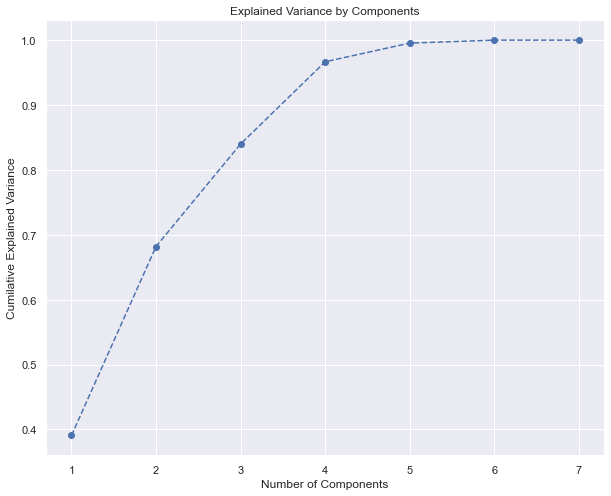

In [15]:
plt.figure(figsize = (10,8))
plt.plot(range(1,8),pca.explained_variance_ratio_.cumsum(),marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumilative Explained Variance')
plt.show()

In [16]:
pca = PCA(n_components= 4)

In [17]:
pca.fit(X_std)
# pca.components_

PCA(n_components=4)

In [18]:
X_standard = pd.DataFrame(X_std, columns = X.columns)
# X_standard

In [19]:
components = pd.DataFrame(pca.components_,columns = X_standard.columns,index = ['PC-1','PC-2','PC-3','PC-4'])
components

,CLIP LENGTH,SUM DURATION,WHITE SPACE,OVERLAP COUNT,MEDIAN DIST B/W ANNS,MEDIAN DURATION,OFFSET COUNT
PC-1,0.350024,0.395778,0.213019,0.467136,-0.271629,-0.297817,0.542929
PC-2,0.564268,0.153108,0.606259,-0.248315,0.396006,0.168797,-0.208894
PC-3,0.041911,0.637078,-0.294140,-0.067850,-0.214479,0.672386,-0.056122
PC-4,-0.119216,-0.157298,-0.060357,0.530573,0.641051,0.413657,0.306325


In [20]:
pca.transform(X_std)
scores_pca = pca.transform(X_std)
scores_pca

array([[ 1.85310747e+00,  1.41397439e+00,  3.63449949e-01,
        -1.22092905e+00],
       [-1.71947612e-01,  1.17981139e+00,  1.78226187e+00,
         3.83653346e-01],
       [-5.04345092e-01, -2.23462486e+00, -7.98997537e-01,
        -7.33948281e-01],
       [ 4.01214228e+00, -2.28505767e+00, -7.08493198e-01,
         1.76645392e+00],
       [-1.92125098e+00, -3.09647574e-01,  1.10141044e+00,
         1.09294068e+00],
       [ 6.03660278e+00, -2.12599280e+00, -1.47928335e-01,
         2.32812304e+00],
       [-6.71709606e-01, -1.10785568e+00, -1.32399090e-01,
        -5.09339472e-01],
       [-5.31220935e-01,  1.08818583e+00,  1.98136276e+00,
         4.26864338e-01],
       [-1.16401299e+00, -6.80696275e-01, -1.21394493e+00,
         1.29571151e-02],
       [-5.19026144e-01,  1.67704765e+00, -6.75028025e-01,
         6.55016397e-01],
       [-3.37490275e-01,  4.46676860e+00, -1.62717611e+00,
         1.86560455e+00],
       [-1.94778474e+00, -4.92778888e-01,  5.58387308e-02,
      

In [21]:
scores_components = pd.DataFrame(scores_pca,columns = ['PC-1','PC-2','PC-3','PC-4'])
scores_components['IN FILE'],scores_components['LAST MOD BY'], scores_components['Genus'] = Y_3,Y_2, Y
scores_components

,PC-1,PC-2,PC-3,PC-4,IN FILE,LAST MOD BY,Genus
0,1.853107,1.413974,0.363450,-1.220929,Ramphocaenus-melanurus-149300.wav,EdZamora,Ramphocaenus
1,-0.171948,1.179811,1.782262,0.383653,Ramphocaenus-melanurus-27794.wav,EdZamora,Ramphocaenus
2,-0.504345,-2.234625,-0.798998,-0.733948,Ramphocaenus-sticturus-2312.wav,EdZamora,Ramphocaenus
3,4.012142,-2.285058,-0.708493,1.766454,Ramphocaenus-sticturus-424936.wav,EdZamora,Ramphocaenus
4,-1.921251,-0.309648,1.101410,1.092941,Ramphocaenus-sticturus-91665.wav,EdZamora,Ramphocaenus
5,6.036603,-2.125993,-0.147928,2.328123,Ramphocaenus-sticturus-91680.wav,EdZamora,Ramphocaenus
6,-0.671710,-1.107856,-0.132399,-0.509339,Ramphotrigon-fuscicauda-102716.wav,EdZamora,Ramphotrigon
7,-0.531221,1.088186,1.981363,0.426864,Ramphotrigon-fuscicauda-229017.wav,EdZamora,Ramphotrigon
8,-1.164013,-0.680696,-1.213945,0.012957,Ramphotrigon-megacephalum-206161.wav,EdZamora,Ramphotrigon
9,-0.519026,1.677048,-0.675028,0.655016,Ramphotrigon-ruficauda-27821.wav,EdZamora,Ramphotrigon


In [22]:
# Within Cluster Sum of Squares
# Elbow Technique

wcss = []
for i in range(1,21):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

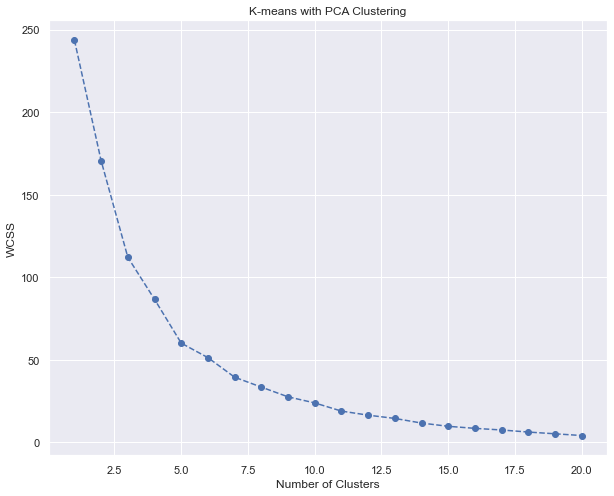

In [23]:
plt.figure(figsize = (10,8))
plt.plot(range(1,21),wcss,marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

In [24]:
kmeans_pca = KMeans(n_clusters = 5, init = 'k-means++',random_state = 42)

In [25]:
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=5, random_state=42)

In [26]:
df_segm_pca_kmeans = pd.concat([X.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-4:] = ['PCA1','PCA2','PCA3','PCA4']

df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [27]:
df_segm_pca_kmeans.head()

,CLIP LENGTH,SUM DURATION,WHITE SPACE,OVERLAP COUNT,MEDIAN DIST B/W ANNS,MEDIAN DURATION,OFFSET COUNT,PCA1,PCA2,PCA3,PCA4,Segment K-means PCA
0,73.6131,30.8374,42.7757,0,1.109900e+00,0.44995,28,1.853107,1.413974,0.363450,-1.220929,4
1,54.0473,25.2886,28.7587,0,2.729900e+00,2.62980,11,-0.171948,1.179811,1.782262,0.383653,0
2,10.1094,6.5372,3.5722,0,1.213000e-01,0.24270,27,-0.504345,-2.234625,-0.798998,-0.733948,1
3,38.8320,18.0810,20.7510,50,-1.110223e-15,0.19000,98,4.012142,-2.285058,-0.708493,1.766454,2
4,21.3420,8.7208,12.6212,0,3.160300e+00,2.95020,3,-1.921251,-0.309648,1.101410,1.092941,0


In [28]:
df_segm_pca_kmeans['Cluster'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0:'first',1:'second',2:'third',3:'fourth',4:'fifth'})
# df_segm_pca_kmeans

In [29]:
df_segm_pca_kmeans['IN FILE'],df_segm_pca_kmeans['LAST MOD BY'], df_segm_pca_kmeans['Genus'] = Y_3,Y_2, Y

In [30]:
df_segm_pca_kmeans

,CLIP LENGTH,SUM DURATION,WHITE SPACE,OVERLAP COUNT,MEDIAN DIST B/W ANNS,MEDIAN DURATION,OFFSET COUNT,PCA1,PCA2,PCA3,PCA4,Segment K-means PCA,Cluster,IN FILE,LAST MOD BY,Genus
0,73.61310,30.8374,42.77570,0,1.109900e+00,0.44995,28,1.853107,1.413974,0.363450,-1.220929,4,fifth,Ramphocaenus-melanurus-149300.wav,EdZamora,Ramphocaenus
1,54.04730,25.2886,28.75870,0,2.729900e+00,2.62980,11,-0.171948,1.179811,1.782262,0.383653,0,first,Ramphocaenus-melanurus-27794.wav,EdZamora,Ramphocaenus
2,10.10940,6.5372,3.57220,0,1.213000e-01,0.24270,27,-0.504345,-2.234625,-0.798998,-0.733948,1,second,Ramphocaenus-sticturus-2312.wav,EdZamora,Ramphocaenus
3,38.83200,18.0810,20.75100,50,-1.110223e-15,0.19000,98,4.012142,-2.285058,-0.708493,1.766454,2,third,Ramphocaenus-sticturus-424936.wav,EdZamora,Ramphocaenus
4,21.34200,8.7208,12.62120,0,3.160300e+00,2.95020,3,-1.921251,-0.309648,1.101410,1.092941,0,first,Ramphocaenus-sticturus-91665.wav,EdZamora,Ramphocaenus
5,53.42040,29.1900,24.23040,56,0.000000e+00,0.17000,151,6.036603,-2.125993,-0.147928,2.328123,2,third,Ramphocaenus-sticturus-91680.wav,EdZamora,Ramphocaenus
6,23.18400,10.5472,12.63680,0,8.728000e-01,0.95970,11,-0.671710,-1.107856,-0.132399,-0.509339,1,second,Ramphotrigon-fuscicauda-102716.wav,EdZamora,Ramphotrigon
7,51.76800,20.1693,31.59870,0,1.690050e+00,3.24490,8,-0.531221,1.088186,1.981363,0.426864,0,first,Ramphotrigon-fuscicauda-229017.wav,EdZamora,Ramphotrigon
8,21.99510,3.3693,18.62580,0,3.049350e+00,0.59485,6,-1.164013,-0.680696,-1.213945,0.012957,1,second,Ramphotrigon-megacephalum-206161.wav,EdZamora,Ramphotrigon
9,54.15180,10.9202,43.23160,0,5.195200e+00,1.35500,8,-0.519026,1.677048,-0.675028,0.655016,3,fourth,Ramphotrigon-ruficauda-27821.wav,EdZamora,Ramphotrigon


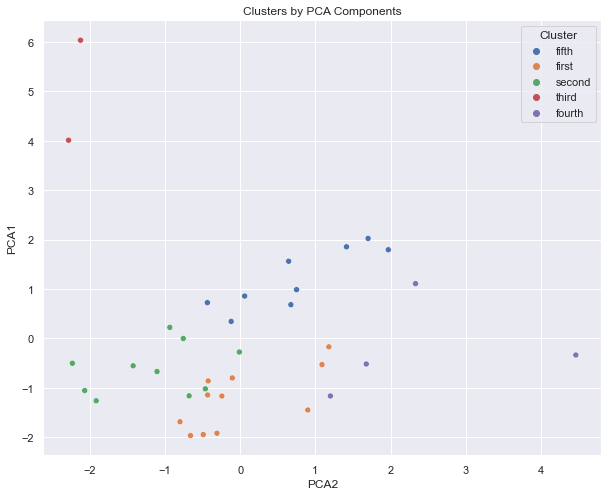

In [31]:
plt.figure(figsize=(10,8))
sns.scatterplot(data = df_segm_pca_kmeans,x = 'PCA2', y = 'PCA1', hue = df_segm_pca_kmeans['Cluster'])
plt.title('Clusters by PCA Components')
plt.show()

In [32]:
import plotly.express as px 
import plotly.graph_objects as go
import numpy as np


fig = px.scatter_3d(df_segm_pca_kmeans, 
                    x="PCA1", 
                    y="PCA2", 
                    z='PCA3', 
                    color = df_segm_pca_kmeans['Cluster'],
                    hover_name = list(tuple(zip(df_segm_pca_kmeans['IN FILE'],df_segm_pca_kmeans['LAST MOD BY'])))) 


#color = Y, color_discrete_sequence= px.colors.qualitative.G10)


clust_1 = df_segm_pca_kmeans[df_segm_pca_kmeans['Cluster'] == 'first']
x, y, z = clust_1['PCA1'], clust_1['PCA2'], clust_1['PCA3']
fig.add_trace(go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, color='lightblue', opacity=0.50)]).data[0])


clust_2 = df_segm_pca_kmeans[df_segm_pca_kmeans['Cluster'] == 'second']
x2, y2, z2 = clust_2['PCA1'], clust_2['PCA2'], clust_2['PCA3']
fig.add_trace(go.Figure(data=[go.Mesh3d(x=x2, y=y2, z=z2, color='lightblue', opacity=0.50)]).data[0])


clust_3 = df_segm_pca_kmeans[df_segm_pca_kmeans['Cluster'] == 'third']
x3, y3, z3 = clust_3['PCA1'], clust_3['PCA2'], clust_3['PCA3']
fig.add_trace(go.Figure(data=[go.Mesh3d(x=x3, y=y3, z=z3, color='lightblue', opacity=0.50)]).data[0])


clust_4 = df_segm_pca_kmeans[df_segm_pca_kmeans['Cluster'] == 'fourth']
x4, y4, z4 = clust_4['PCA1'], clust_4['PCA2'], clust_4['PCA3']
fig.add_trace(go.Figure(data=[go.Mesh3d(x=x4, y=y4, z=z4, color='lightblue', opacity=0.50)]).data[0])


clust_5 = df_segm_pca_kmeans[df_segm_pca_kmeans['Cluster'] == 'fifth']
x5, y5, z5 = clust_5['PCA1'], clust_5['PCA2'], clust_5['PCA3']
fig.add_trace(go.Figure(data=[go.Mesh3d(x=x5, y=y5, z=z5, color='lightblue', opacity=0.50)]).data[0])


fig.update_layout(title_text= (' & '.join(df_segm_pca_kmeans['LAST MOD BY'].unique()) + ' Annotations'), title_x=0.5)
fig.show()

In [33]:
annotator_genus_df

,IN FILE,CLIP LENGTH,SUM DURATION,WHITE SPACE,OVERLAP COUNT,MEDIAN DIST B/W ANNS,MEDIAN DURATION,OFFSET COUNT,LAST MOD BY,Genus
1810,Ramphocaenus-melanurus-149300.wav,73.61310,30.8374,42.77570,0,1.109900e+00,0.44995,28,EdZamora,Ramphocaenus
1811,Ramphocaenus-melanurus-27794.wav,54.04730,25.2886,28.75870,0,2.729900e+00,2.62980,11,EdZamora,Ramphocaenus
1812,Ramphocaenus-sticturus-2312.wav,10.10940,6.5372,3.57220,0,1.213000e-01,0.24270,27,EdZamora,Ramphocaenus
1813,Ramphocaenus-sticturus-424936.wav,38.83200,18.0810,20.75100,50,-1.110223e-15,0.19000,98,EdZamora,Ramphocaenus
1814,Ramphocaenus-sticturus-91665.wav,21.34200,8.7208,12.62120,0,3.160300e+00,2.95020,3,EdZamora,Ramphocaenus
1815,Ramphocaenus-sticturus-91680.wav,53.42040,29.1900,24.23040,56,0.000000e+00,0.17000,151,EdZamora,Ramphocaenus
1823,Ramphotrigon-fuscicauda-102716.wav,23.18400,10.5472,12.63680,0,8.728000e-01,0.95970,11,EdZamora,Ramphotrigon
1824,Ramphotrigon-fuscicauda-229017.wav,51.76800,20.1693,31.59870,0,1.690050e+00,3.24490,8,EdZamora,Ramphotrigon
1826,Ramphotrigon-megacephalum-206161.wav,21.99510,3.3693,18.62580,0,3.049350e+00,0.59485,6,EdZamora,Ramphotrigon
1828,Ramphotrigon-ruficauda-27821.wav,54.15180,10.9202,43.23160,0,5.195200e+00,1.35500,8,EdZamora,Ramphotrigon


In [34]:
kaleidoscope_format = pd.read_csv('for_data_science_newline_fixed.csv')
for_kaleidoscope = kaleidoscope_format[kaleidoscope_format['IN FILE'].isin(df_segm_pca_kmeans['IN FILE'].to_list())] 
for_kaleidoscope

,IN FILE,CLIP LENGTH,OFFSET,DURATION,MAX FREQ,MIN FREQ,SAMPLE RATE,MANUAL ID,TIME_SPENT,LAST MOD BY,LAST MOD DATE,LAST MOD TIME
22645,Ramphocaenus-melanurus-27794.wav,54.0473,3.1902,2.4498,24000,0,44100,Ramphocaenus melanurus Trilling Gnatwren,117.773,EdZamora,11/21/2021,14:47:37
22646,Ramphocaenus-melanurus-27794.wav,54.0473,9.8698,2.7199,24000,0,44100,Ramphocaenus melanurus Trilling Gnatwren,117.775,EdZamora,11/21/2021,14:47:37
22647,Ramphocaenus-melanurus-27794.wav,54.0473,23.2392,2.6298,24000,0,44100,Ramphocaenus melanurus Trilling Gnatwren,117.777,EdZamora,11/21/2021,14:47:37
22648,Ramphocaenus-melanurus-27794.wav,54.0473,7.7699,1.6799,24000,0,44100,Ramphocaenus melanurus Trilling Gnatwren,117.775,EdZamora,11/21/2021,14:47:37
22649,Ramphocaenus-melanurus-27794.wav,54.0473,16.1795,2.6299,24000,0,44100,Ramphocaenus melanurus Trilling Gnatwren,117.776,EdZamora,11/21/2021,14:47:37
...,...,...,...,...,...,...,...,...,...,...,...,...
24643,Sclerurus-mexicanus-534691.wav,77.6400,64.9351,0.2300,24000,0,48000,Sclerurus mexicanus Tawny-throated Leaftosser,239.893,EdZamora,11/21/2021,09:02:49
24644,Sclerurus-mexicanus-534691.wav,77.6400,66.7951,0.2500,24000,0,48000,Sclerurus mexicanus Tawny-throated Leaftosser,239.894,EdZamora,11/21/2021,09:02:49
24645,Sclerurus-mexicanus-534691.wav,77.6400,70.8751,0.2300,24000,0,48000,Sclerurus mexicanus Tawny-throated Leaftosser,239.895,EdZamora,11/21/2021,09:02:49
24646,Sclerurus-mexicanus-534691.wav,77.6400,72.9151,0.2000,24000,0,48000,Sclerurus mexicanus Tawny-throated Leaftosser,239.895,EdZamora,11/21/2021,09:02:49
